Hay 16641 nodos y 32768 elementos
Iter 1: J = 1.266269e-01, ||grad|| = 6.90e-05
Iter 2: J = 1.266269e-01, ||grad|| = 6.90e-05
Iter 3: J = 1.266268e-01, ||grad|| = 6.90e-05
Iter 4: J = 1.266268e-01, ||grad|| = 6.90e-05
Iter 5: J = 1.266266e-01, ||grad|| = 6.90e-05
Iter 6: J = 1.266263e-01, ||grad|| = 6.90e-05
Iter 7: J = 1.266257e-01, ||grad|| = 6.90e-05
Iter 8: J = 1.266245e-01, ||grad|| = 6.90e-05
Iter 9: J = 1.266220e-01, ||grad|| = 6.90e-05
Iter 10: J = 1.266172e-01, ||grad|| = 6.89e-05
Iter 11: J = 1.266074e-01, ||grad|| = 6.88e-05
Iter 12: J = 1.265881e-01, ||grad|| = 6.86e-05
Iter 13: J = 1.265496e-01, ||grad|| = 6.83e-05
Iter 14: J = 1.264737e-01, ||grad|| = 6.75e-05
Iter 15: J = 1.263259e-01, ||grad|| = 6.61e-05
Iter 16: J = 1.260461e-01, ||grad|| = 6.32e-05
Iter 17: J = 1.255451e-01, ||grad|| = 5.77e-05
Iter 18: J = 1.247462e-01, ||grad|| = 4.78e-05
Iter 19: J = 1.237519e-01, ||grad|| = 3.16e-05
Iter 20: J = 1.230556e-01, ||grad|| = 1.10e-05
Iter 21: J = 1.229505e-01, ||grad||

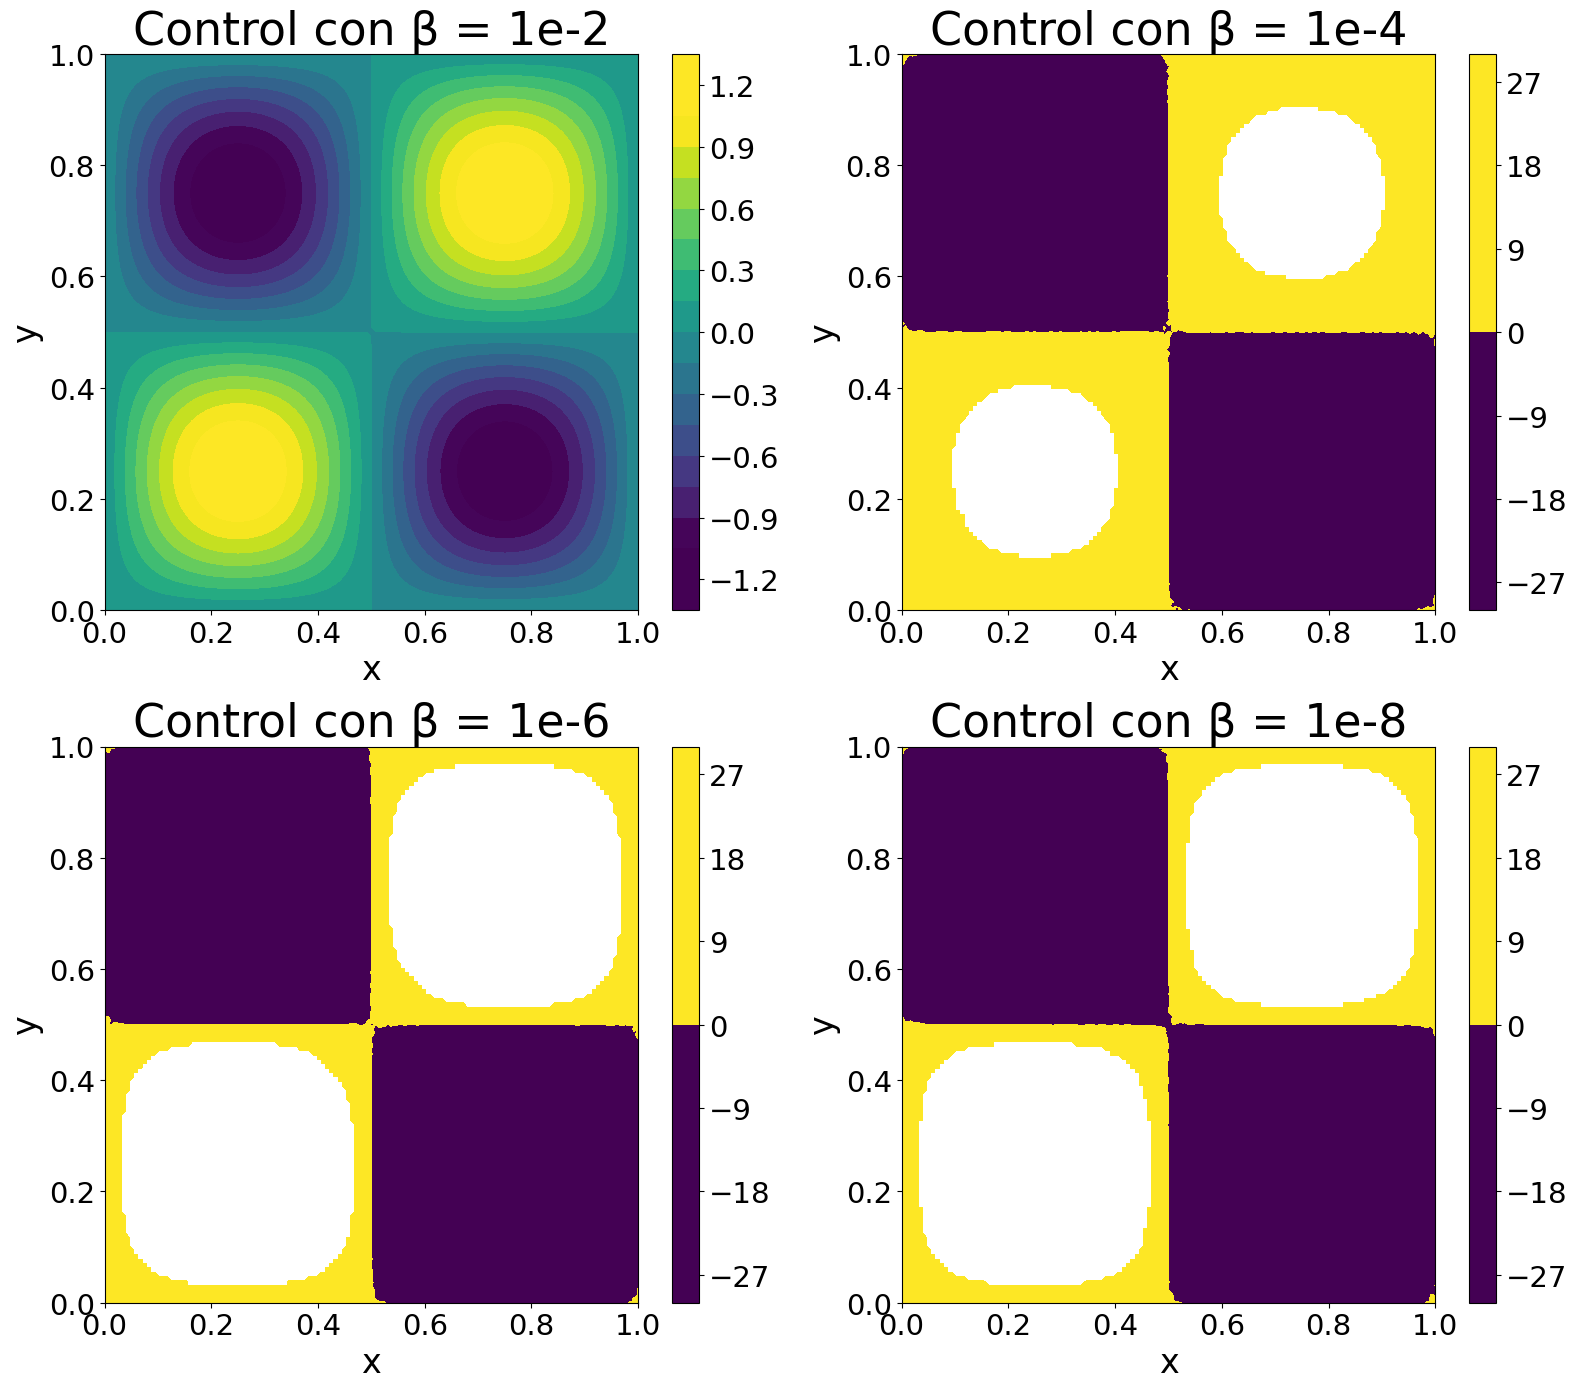

In [14]:
#Operaciones matriciales
import numpy as np
#Crear el espacio de aproximación
from skfem import *
from skfem.models.poisson import laplace, mass
#Resolver los sistemas lineales
from scipy.sparse.linalg import spsolve
#Graficar
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# --------------------------
# Proyección de z_d(x, y)
# --------------------------

#Definimos la función objetivo z_d(x, y)
#def z_d(x, y):
#    return 10 * x * (1 - x) * y * (1 - y)
def z_d(x, y):
    return np.sin(2*np.pi*x)*np.sin(2*np.pi*y)

#Evaluamos z_d en las coordenadas de los grados de libertad de la base
#Se separan las coordenadas x e y, y luego se evalúa z_d en todos los dofs.
def Getzd(basis):
    x = basis.doflocs[0, :]  #Coordenadas x
    y = basis.doflocs[1, :]  #Coordenadas y
    return z_d(x, y)         #Evaluación de z_d en (x, y)


# --------------------------
# Ecuaciones del sistema
# --------------------------
#y(u) a traves de la ecuacion de estado.
def gety(A, M, u):
    y = spsolve(A, M @ u)
    return y

#p(y) a traves de la ecuacion adjunta.
def getp(A, M, zd, y):
    return spsolve(A, -M @ (y - zd))

#Funcion objetivo J(u, y(u)).
def J(M, beta, zd, y, u):
    return 0.5 * (y - zd).T @ M @ (y - zd) + 0.5 * beta * u.T @ M @ u

#Gradiente de la funcion objetivo
def grad_J(M, beta, u, p):
    return beta * M @ u - M @ p

#Hola
def Proy(a, u):
    if a == None:
        return u
    return np.clip(u, -a, a)

# --------------------------
# Malla y espacios
# --------------------------

#Generamos el espacio de aproximación
def getSpace(ref):
    #Generamos una malla triangular en el dominio unitario, refinada ref veces.
    mesh = MeshTri().refined(ref)

    #Definimos el espacio de aproximación usando funciones lineales por partes.
    basis = Basis(mesh, ElementTriP1())

    #Ensamblamos la matriz de rigidez.
    A = asm(laplace, basis).tocsc()

    #Ensamblamos la matriz de masa.
    M = asm(mass, basis).tocsc()

    #Obtenemos los grados de libertad.
    N = basis.N

    print(f"Hay {mesh.p.shape[1]} nodos y {mesh.t.shape[1]} elementos")

    #Aqui guardaremos el ID de los nodos del borde.
    dofs = []

    #Obtenemos las coordenadas de los nodos.
    nodes = basis.doflocs.T

    #Recorremos cada nodo y verifica si está en el borde.
    for i, (x, y) in enumerate(nodes):
        if (abs(x) < 1e-10 or abs(x-1) < 1e-10 or abs(y) < 1e-10 or abs(y-1) < 1e-10):
            dofs.append(i)

    #Lo convertimos a un arreglo de NumPy.
    dofs = np.array(dofs, dtype=int)

    #Dejamos A en formato LIL para poder modificarla.
    A = A.tolil()

    #Imponemos condiciones de Dirichlet homogéneas en el borde.
    for dof in dofs:
        A[:, dof] = 0
        A[dof, dof] = 1

    #Reconvertimos A a formato CSC.
    A = A.tocsc()

    #Retornamos los objetos necesarios
    return basis, A, M, N


# --------------------------
# Método de descenso de gradiente
# --------------------------
#Implementamos el metodo del gradiente
def GradientMethod(beta, a, sigma=1e-2, rho=0.5, t0=1.0, tmin=1e-20, tol=1e-18, Kmax=200, ref = 7):
    #Obtenemos los elementos necesarios del espacio de aproximacion.
    basis, A, M, N = getSpace(ref)
    
    #Obtenemos la proyeccion de la funcion objetivo sobre el espacio aproximado.
    zd = Getzd(basis)
    
    #Inicializamos el control u de forma aleatoria.
    u = Proy(a, np.random.rand(N))
    #Obtenemos y(u) de la ecuacion de estado.
    y = gety(A, M, u)
    #Obtenemos p(y) de la ecuacion adjunta.
    p = getp(A, M, zd, y)
    #Obtenemos el gradiente de la funcion objetivo.
    grad = grad_J(M, beta, u, p)
    #Obtenemos la norma inicial del gradiente para usarla de referencia.
    norm_grad0 = np.linalg.norm(grad)
    #Obtenemos el valor de la funcion objetivo en el punto inicial.
    J_val = J(M, beta, zd, y, u)

    #Inicializamos el contador de iteraciones.
    k = 0
    #Inicializamos el paso del metodo de descenso de gradiente.
    t = t0
    while np.linalg.norm(grad) / norm_grad0 > tol and k < Kmax:
        #Como no reinicializamos el paso, probamos amplificarlo una vez.
        t /= rho
        
        #Intentamos dar un paso usando el valor t actual.
        while t > tmin:
            #Actualizamos de u usando el gradiente y el paso t.
            u_new = Proy(a, u - t * grad)
            #Obtenemos y(u) de la ecuacion de estado.
            y_new = gety(A, M, u_new)
            #Obtenemos p(y) de la ecacion adjunta.
            p_new = getp(A, M, zd, y_new)
            #Calculamos el nuevo valor de la funcion objetivo.
            J_new = J(M, beta, zd, y_new, u_new)

            #Verificamos la condicion de Armijo.
            if J_new <= J_val - sigma * t * (grad @ grad):
                #Actualizamos u, y, p, J y su gradiente con los nuevos valores.
                u = u_new
                y = y_new
                p = p_new
                grad = grad_J(M, beta, u, p)
                J_val = J_new
                #Se incrementa el contador de iteraciones.
                k += 1
                #Obtenemos informacion relevante para validar que esta funcionando.
                print(f"Iter {k}: J = {J_val:.6e}, ||grad|| = {np.linalg.norm(grad):.2e}")
                break
            else:
                #Si la condición de Armijo no se cumple, se reduce el paso t y se vuelve a intentar.
                t *= rho
        else:
            #Si no se encuentra un valor adecuado para t, se termina.
            print("Backtracking falló.")
            break

    #Se devuelve el espacio de aproximación, junto con la solucion
    return basis, zd, u, y, p


# --------------------------
# Visualización
# --------------------------

#Creamos una funcion para graficar la solucion
def show(basis, zd, u, y, p):
    
    #Obtenemos las coordenadas de la base
    x = basis.doflocs[0, :]
    y_coords = basis.doflocs[1, :]
    
    #Crear una figura con 4 subplots
    fig, axs = plt.subplots(2, 2, figsize=(16, 14))
    
    #Los titulos de cada subplot
    titles = [
        "Control con β = 1e-2", 
        "Control con β = 1e-4", 
        "Control con β = 1e-6", 
        "Control con β = 1e-8"
    ]
    #titles = ["Estado con a = 20", "Estado con a = 35", "Estado con a = 50", "Estado con u irrestricto"]
    #Y los valores de las funciones
    data = [zd, u, y, p]
    
    title_size = 33
    label_size = 24
    tick_size = 21
    cbar_label_size = 21
    
    #Graficamos cada una de las soluciones
    for i, ax in enumerate(axs.flat):
        #Graficamos la solucion suavizada
        #tcf = ax.tricontourf(x, y_coords, data[i], levels=20, cmap='viridis')
        tcf = ax.tricontourf(x, y_coords, data[i], levels=20, cmap='viridis', vmin = -1, vmax = 1)
        #Configuramos la barra de colores
        cbar = fig.colorbar(tcf, ax=ax, format=ScalarFormatter(useOffset=False))
        cbar.ax.tick_params(labelsize=cbar_label_size)
        #Ponemos el titulo y la leyenda de los ejes
        ax.set_title(titles[i], fontsize = title_size)
        ax.set_xlabel('x', fontsize = label_size)
        ax.set_ylabel('y', fontsize = label_size)
        
        ax.tick_params(axis='both', which='major', labelsize=tick_size)
    
    #Ajustamos los espacios entre subplots.
    plt.tight_layout()
    #Mostramos los graficos
    plt.show()

# --------------------------
# Ejecución modificada
# --------------------------
if __name__ == "__main__":
    
    #basis, zd, u, y, p = GradientMethod(1e-3, None)
    
    #show(basis, zd, u, y, p)
    
    basis, zd, u1, y1, p = GradientMethod(1e-2, 30)
    basis, zd, u2, y2, p = GradientMethod(1e-4, 30)
    basis, zd, u3, y3, p = GradientMethod(1e-6, 30)
    basis, zd, u4, y4, p = GradientMethod(1e-8, 30)
    
    # Llamar a la nueva función que muestra todos los gráficos juntos
    #show(basis, zd, u, y, p)
    show(basis, u1, u2, u3, u4)

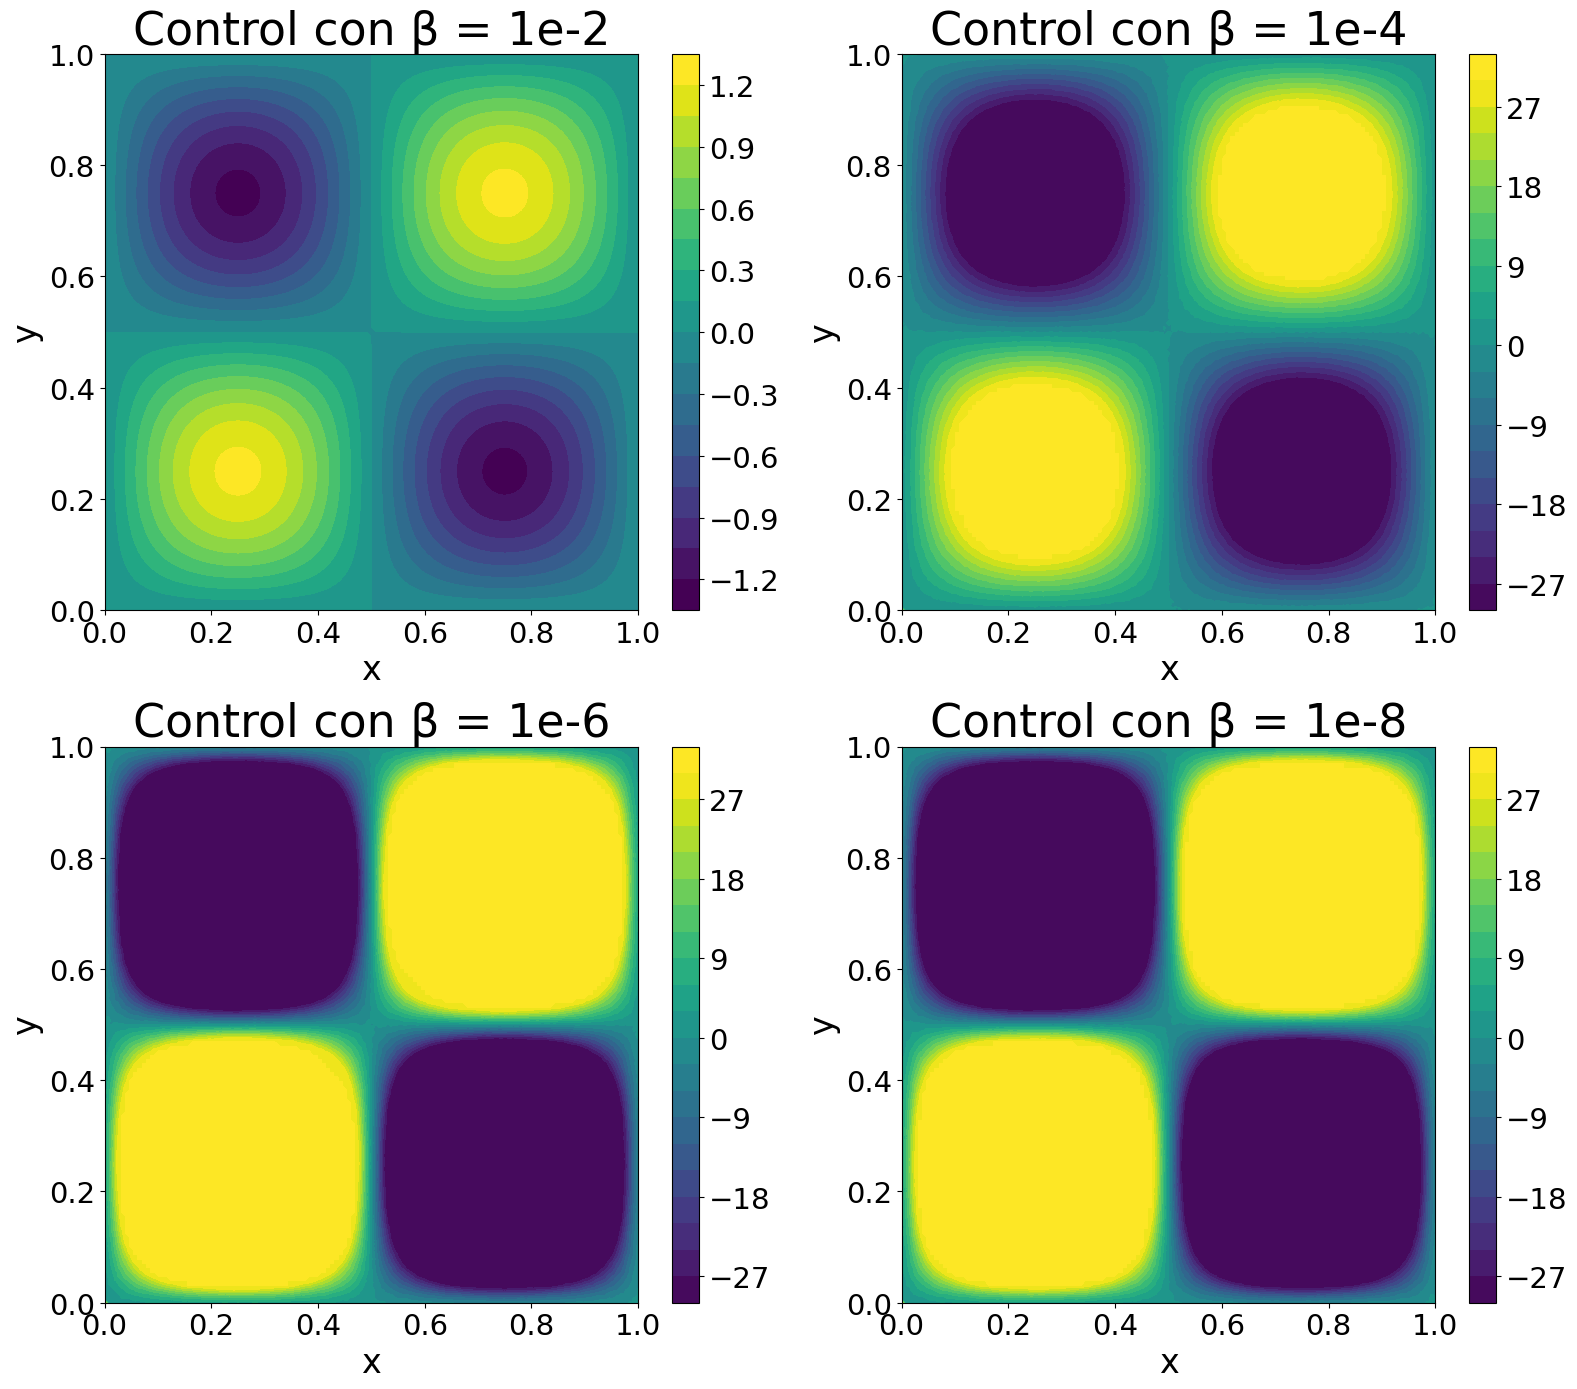

In [16]:
def show(basis, zd, u, y, p):
    
    #Obtenemos las coordenadas de la base
    x = basis.doflocs[0, :]
    y_coords = basis.doflocs[1, :]
    
    #Crear una figura con 4 subplots
    fig, axs = plt.subplots(2, 2, figsize=(16, 14))
    
    #Los titulos de cada subplot
    titles = [
        "Control con β = 1e-2", 
        "Control con β = 1e-4", 
        "Control con β = 1e-6", 
        "Control con β = 1e-8"
    ]
    #Y los valores de las funciones
    data = [zd, u, y, p]
    
    title_size = 33
    label_size = 24
    tick_size = 21
    cbar_label_size = 21
    
    #Graficamos cada una de las soluciones
    for i, ax in enumerate(axs.flat):
        #maximo = np.unique(data[i])[-3]
        #Graficamos la solucion suavizada
        if i == 0:
            tcf = ax.tricontourf(x, y_coords, data[i], levels=20, cmap='viridis', vmin = -1.25, vmax = 1.25)
        else:
            data[i][0] = 30.000001
            tcf = ax.tricontourf(x, y_coords, data[i], levels=20, cmap='viridis', vmin = -30, vmax = 30)
        #print(maximo)
        #Configuramos la barra de colores
        cbar = fig.colorbar(tcf, ax=ax, format=ScalarFormatter(useOffset=False))
        #Ponemos el titulo y la leyenda de los ejes
        cbar.ax.tick_params(labelsize=cbar_label_size)
        #Ponemos el titulo y la leyenda de los ejes
        ax.set_title(titles[i], fontsize = title_size)
        ax.set_xlabel('x', fontsize = label_size)
        ax.set_ylabel('y', fontsize = label_size)
        
        ax.tick_params(axis='both', which='major', labelsize=tick_size)
    
    #Ajustamos los espacios entre subplots.
    plt.tight_layout()
    #Mostramos los graficos
    plt.show()

# --------------------------
# Ejecución modificada
# --------------------------
if __name__ == "__main__":
    
    # Llamar a la nueva función que muestra todos los gráficos juntos
    #show(basis, zd, u, y, p)
    show(basis, u1, u2, u3, u4)